# Text Mining with Songs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) 
import glob
import plotly.express as px
import plotly.graph_objects as go
from string import punctuation
import re
from nltk import sent_tokenize,word_tokenize,TweetTokenizer
from nltk.tokenize import LineTokenizer 
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
from wordcloud import WordCloud, STOPWORDS 
from nltk.stem import WordNetLemmatizer   
from nltk import pos_tag,FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.io as pio
pio.renderers.default = "svg"

## Getting the Song lyrics

Songs from 46 artists were used as training data for this model.

The songs were obtained using [LyricsGenius API](https://github.com/johnwmillr/LyricsGenius).

The procedure for adding new artists is given in the above link too.

## Loading the Song Lyrics


In [2]:
song_files = glob.glob('data/*.txt')
print('We have {} artists songs'.format(len(song_files)))

We have 46 artists songs


We will now divide the artists based on the music genre of their songs

In [3]:
artist_genres = pd.DataFrame(pd.Series(song_files).apply(lambda x:x.split('\\')[1].split('.')[0]),columns = ['Artist'])
a = ['Pop','RB','RB','Rock','Pop','Rock','Folk','Pop','Rock',
'Pop','Rock','Folk','Kids','Kids','HipHop','Folk','Kids','HipHop','Rap','Rock','Rap','Rock','Folk',
'Folk','Rap','Pop','Folk','HipHop','Kids','Pop','HipHop','RB','Pop','HipHop','Rock','HipHop',
'Rock','HipHop','Kids','Rock','Folk','RB','RB','Rock','Pop','Kids']
artist_genres['genre']=a
artist_genres


,Artist,genre
0,adele,Pop
1,al-green,RB
2,alicia-keys,RB
3,beatles,Rock
4,bieber,Pop
5,blink-182,Rock
6,bob-dylan,Folk
7,britney-spears,Pop
8,bruce-springsteen,Rock
9,bruno-mars,Pop


The 7 broad genres of songs chosen by me are Rock,Pop,Folk,HipHop,Kids music,R&B and Rap
* 10 of the artists sing Rock Songs
* 8 sing Pop Music
* 7 sing Folk music
* 6 sing kids music
* 5 sing R&B music
* 3 sing Rap

In [4]:
#Loading the songs
songs = pd.DataFrame(np.array(artist_genres['Artist']),columns=['Artists'])
songs['genre'] = artist_genres['genre']
songs['text']=0

for i,j in enumerate(song_files):
    with open(j,encoding ='mac-roman') as file:
        songs.loc[i,'text'] =file.read()

## Data Cleaning and Wrangling

In each text \n means new line in the text. Using line_vectorizer easily takes care of that.

For basic analysis of words, we'll remove some text between brackets and square brackets .We will also remove punctuations.

In [5]:
def clean_text(text):
    text = re.sub("[\(\[].*?[\)\]]", "", text) ##Removing the text between brackets
    text = text.lower()
    puncts = '!"#$%&()*+,-./:;<=>?@^_`{|}~'
    for i in puncts:
        text = text.replace(i,'') ##Removing punctuation
    return text
songs['text'] = songs['text'].apply(clean_text)

### Tokenization

Sentence tokenization is the process of splitting up strings into “sentences”

Word tokenization is the process of splitting up “sentences” into “words”

LineTokenizer will tokenize the data based on lines, which we will consider as individual sentences as songs generally do not have grammatical sentences.

While tokenizing ,we will also remove some basic stopwords which are quite common and occur multiple times in the songs

In [6]:
#Defining the stopwords to be removes
stopwords_en = stopwords.words('english')
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
stopwords_nltk_en = set(stopwords_en)
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en)
# Defining the tokenizers
lt = LineTokenizer()
tt = TweetTokenizer()

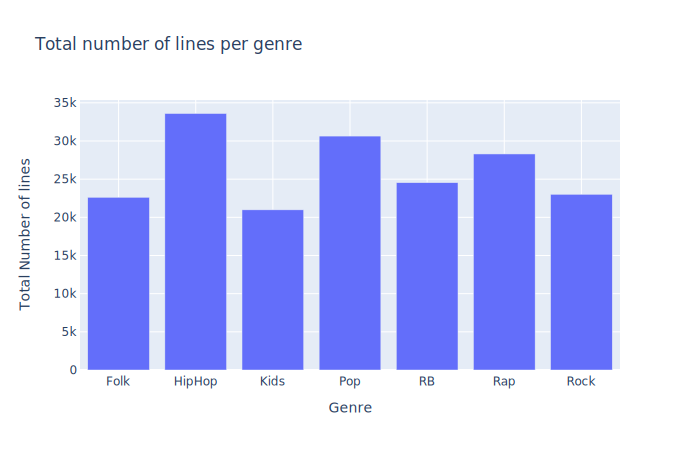

In [7]:
# Finding out the number of lines per genre
b = songs.groupby('genre').aggregate({'text':'\n'.join})
b['line_text'] = b['text'].apply(lambda x:len(lt.tokenize(x)))
fig = px.bar(x = b.index,y = b['line_text'],title = 'Total number of lines per genre')
fig.update_layout(
xaxis_title='Genre',
yaxis_title='Total Number of lines')
fig.show()

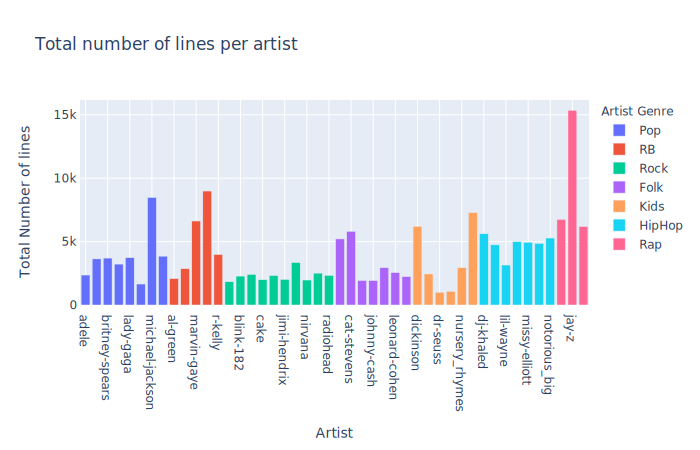

In [8]:
#Finding the total number of lines per artist
songs['line_text'] = songs['text'].apply(lambda x:lt.tokenize(x))
a = songs['line_text'].apply(len)
fig = px.bar(x = songs['Artists'],y = a,title = 'Total number of lines per artist',color = songs['genre'])
fig.update_layout(
xaxis_title='Artist',
yaxis_title='Total Number of lines',
legend_title = 'Artist Genre')
fig.show()

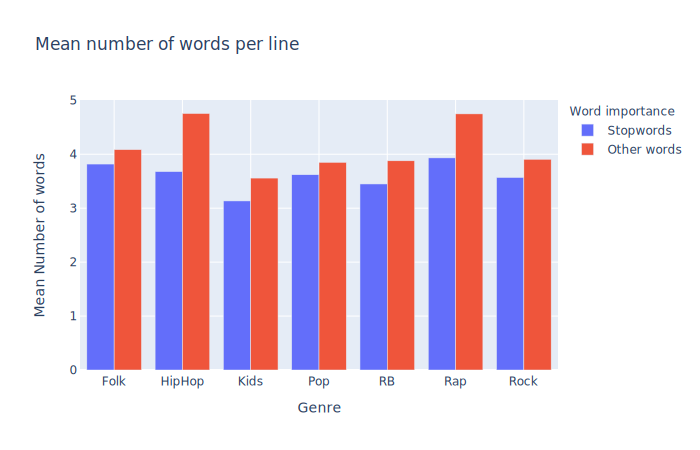

In [9]:
# Finding out per line, how many words are stopwords and how many are not for each genre
songs['mean_words']=0
songs['mean_words_without_stopwords']=0
songs['total_words']=0
songs['total_words_without_stopwords']=0
for i in songs.index:
    a = []
    b = []
    for j,k in enumerate(songs.loc[i,'line_text']):
        word = tt.tokenize(k)
        tokens = [i for i in word if i not in stopwords_en]
        a.append(len(word))
        b.append(len(tokens))
    songs.loc[i,'mean_words'] = np.array(a).mean()
    songs.loc[i,'mean_words_without_stopwords'] = np.array(b).mean()
    songs.loc[i,'total_words']=np.array(a).sum()
    songs.loc[i,'total_words_without_stopwords']=np.array(b).sum()
songs['stop_words']=songs['mean_words']-songs['mean_words_without_stopwords']
songs['total_stop_words']=songs['total_words']-songs['total_words_without_stopwords']

a =  pd.DataFrame(songs.groupby('genre')['stop_words'].mean())
b  = pd.DataFrame(songs.groupby('genre')['mean_words_without_stopwords'].mean())
fig = go.Figure(go.Bar(name='Stopwords',x = a.index,y =a['stop_words']))
fig.add_trace(go.Bar(name ='Other words',x =b.index,y=b['mean_words_without_stopwords']))
fig.update_layout(
    title = 'Mean number of words per line',
    xaxis_title='Genre',
    yaxis_title='Mean Number of words',
    legend_title = 'Word importance',
    barmode='group')
fig.show()

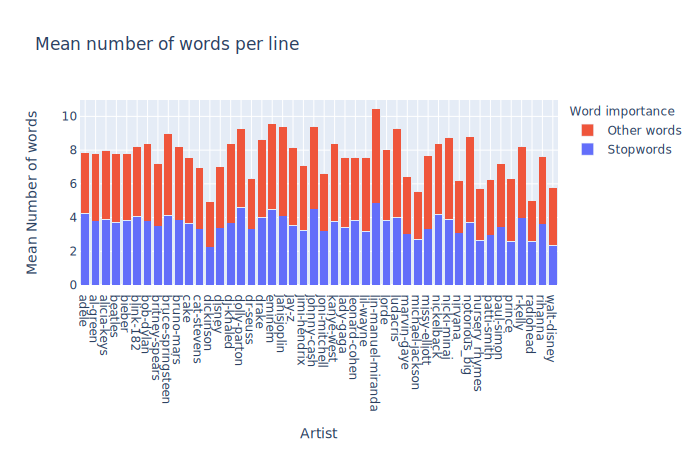

In [10]:
fig = go.Figure(go.Bar(name='Stopwords',x = songs['Artists'],y =songs['stop_words']))
fig.add_trace(go.Bar(name ='Other words',x = songs['Artists'],y=songs['mean_words_without_stopwords']))
fig.update_layout(
    title = 'Mean number of words per line',
    xaxis_title='Artist',
    yaxis_title='Mean Number of words',
    legend_title = 'Word importance',
    barmode='stack',
    xaxis = dict(tickmode= 'linear'))
fig.show()

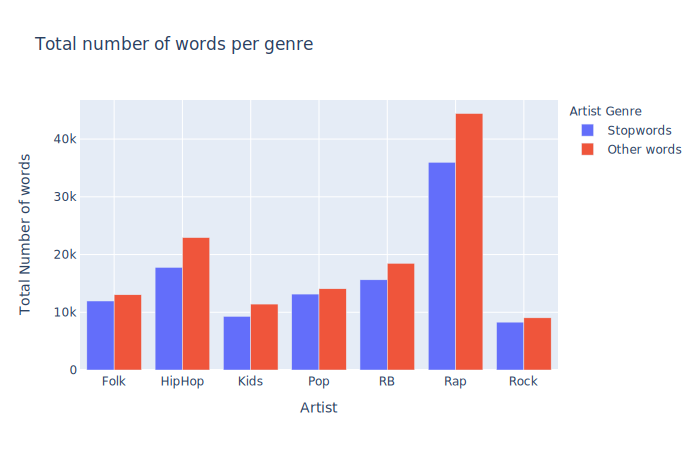

In [11]:
# Getting the total number of words per genre
a =  pd.DataFrame(songs.groupby('genre')['total_stop_words'].mean())
b  = pd.DataFrame(songs.groupby('genre')['total_words_without_stopwords'].mean())
fig = go.Figure(go.Bar(name='Stopwords',x = a.index,y =a['total_stop_words']))
fig.add_trace(go.Bar(name ='Other words',x =b.index,y=b['total_words_without_stopwords']))
fig.update_layout(
    title = 'Total number of words per genre',
    xaxis_title='Artist',
    yaxis_title='Total Number of words',
    legend_title = 'Artist Genre',
    barmode='group')
fig.show()

In [12]:
songs= songs.drop(['line_text','mean_words','mean_words_without_stopwords', 'stop_words', 'total_words',
       'total_words_without_stopwords', 'total_stop_words'],axis=1)

In [13]:
twd = TreebankWordDetokenizer()
def remove_stopwords(text):
    tokens = tt.tokenize(text)
    tokens = [i for i in tokens if i not in stopwords_en]
    text2 = twd.detokenize(tokens)
    return text2
songs['raw_text_without_stopwords'] = songs['text'].apply(remove_stopwords)

## Analyzing the top words per genre

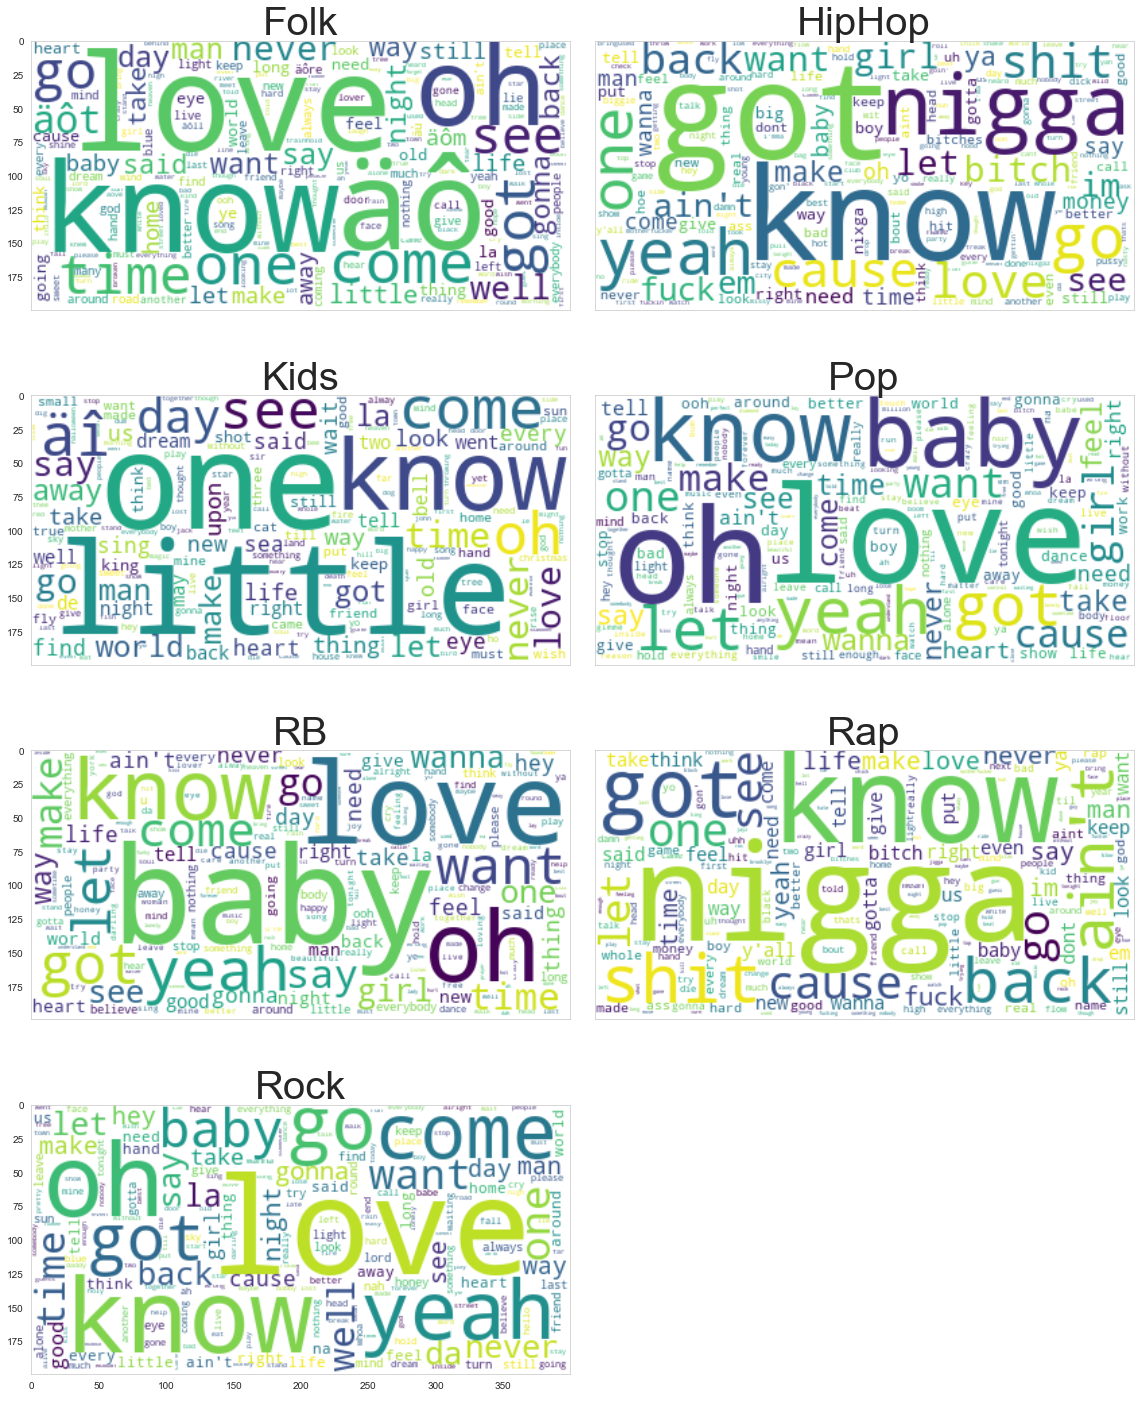

In [14]:
a  = songs[['genre','raw_text_without_stopwords']].groupby('genre').aggregate({'raw_text_without_stopwords':' '.join})

plt.rcParams["axes.grid"] = False
stopwords = set(STOPWORDS)
wc =  WordCloud(background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=100,
                          collocations=False,  
                          random_state=42)
fig,axes = plt.subplots(4,2,figsize=(16,20),sharex=True,sharey=True)
fig.tight_layout()
for i,ax in enumerate(axes.flatten()):
    if i<7:
        ax.imshow(wc.generate(a.iloc[i,0]),interpolation='bilinear')
        ax.set_title(np.array(a.index)[i],fontsize=40)
plt.axis('off')
plt.margins(x=0, y=0)
plt.grid(None)
plt.show()        

## POS (Parts of Speech) Tagging

Part-of-speech tagging is used to assign parts of speech to each word of a given text (such as nouns, verbs, pronouns, adverbs, conjunction, adjectives, interjection) based on its definition and its context. 

### Some common POS tags used in nltk library

![](Capture.PNG)

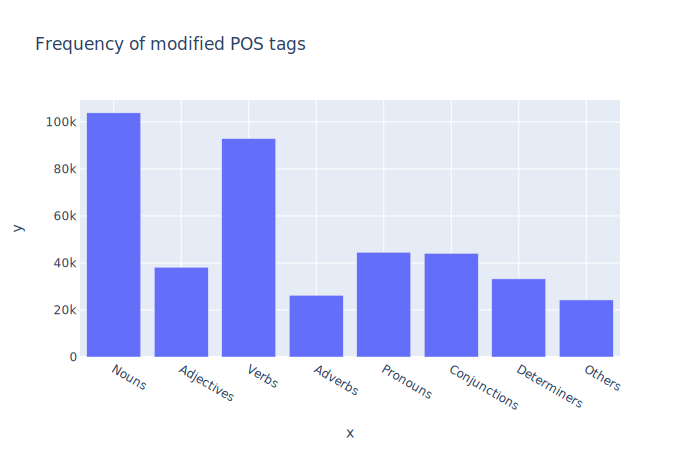

In [15]:
#Finding out common POS tags 
songs['raw_text']=0
for i in songs.index:
    songs.loc[i,'raw_text'] = songs.loc[i,'text'].replace('\n','.')
   
all_songs = songs['raw_text'][0]
for i in range(1,18):
    all_songs+=songs['raw_text'][i]

test_dict = pos_tag(tt.tokenize(all_songs))
tag_fd = FreqDist(tag for (word, tag) in test_dict)

a=[]
b=[]
for i in tag_fd.keys():
    a.append(i)
    b.append(tag_fd[i])
df = pd.DataFrame(a,columns=['POS_tag'])
df['Frequency'] =  b
df = df.sort_values(by='Frequency',ascending=False)

# Grouping some of the common POS tags together to simplify our analysis
q1 = ['NN','NNS','NNPS']
Nouns = [a for (a,b) in test_dict if b in q1]
q2 = ['JJ','JJR','JJS']
Adjectives=[a for (a,b) in test_dict if b in q2]
q3 = ['VB','VBD','VBG','VBN','VBP','VBZ']
Verbs=[a for (a,b) in test_dict if b in q3]
q4 = ['WRB','RB','RBR','RBS']
Adverbs=[a for (a,b) in test_dict if b in q4]
q5 = ['PRP','PRP$','WP','WP$']
Pronouns=[a for (a,b) in test_dict if b in q5]
q6 = ['CC','IN']
Conjunctions=[a for (a,b) in test_dict if b in q6]
q7 = ['DT','PDT']
Determiners= [a for (a,b) in test_dict if b in q7]
q8=['CD','EX','FW','LS','MD','POS','RP','TO','UH']
Others = [a for (a,b) in test_dict if b in q8]

x = ['Nouns','Adjectives','Verbs','Adverbs','Pronouns','Conjunctions','Determiners','Others']
z = [Nouns,Adjectives,Verbs,Adverbs,Pronouns,Conjunctions,Determiners,Others]
y = [len(Nouns),len(Adjectives),len(Verbs),len(Adverbs),len(Pronouns),len(Conjunctions),len(Determiners),len(Others)]
fig  =px.bar(x=x,y=y,title = 'Frequency of modified POS tags')
fig.update_layout()

To simplify things, we will group all these different POS tags and make lower number of final classes

After adjusted POS tags we can see that Nouns and Verbs are the most common Parts of Speech followed by Pronouns and Conjunctions

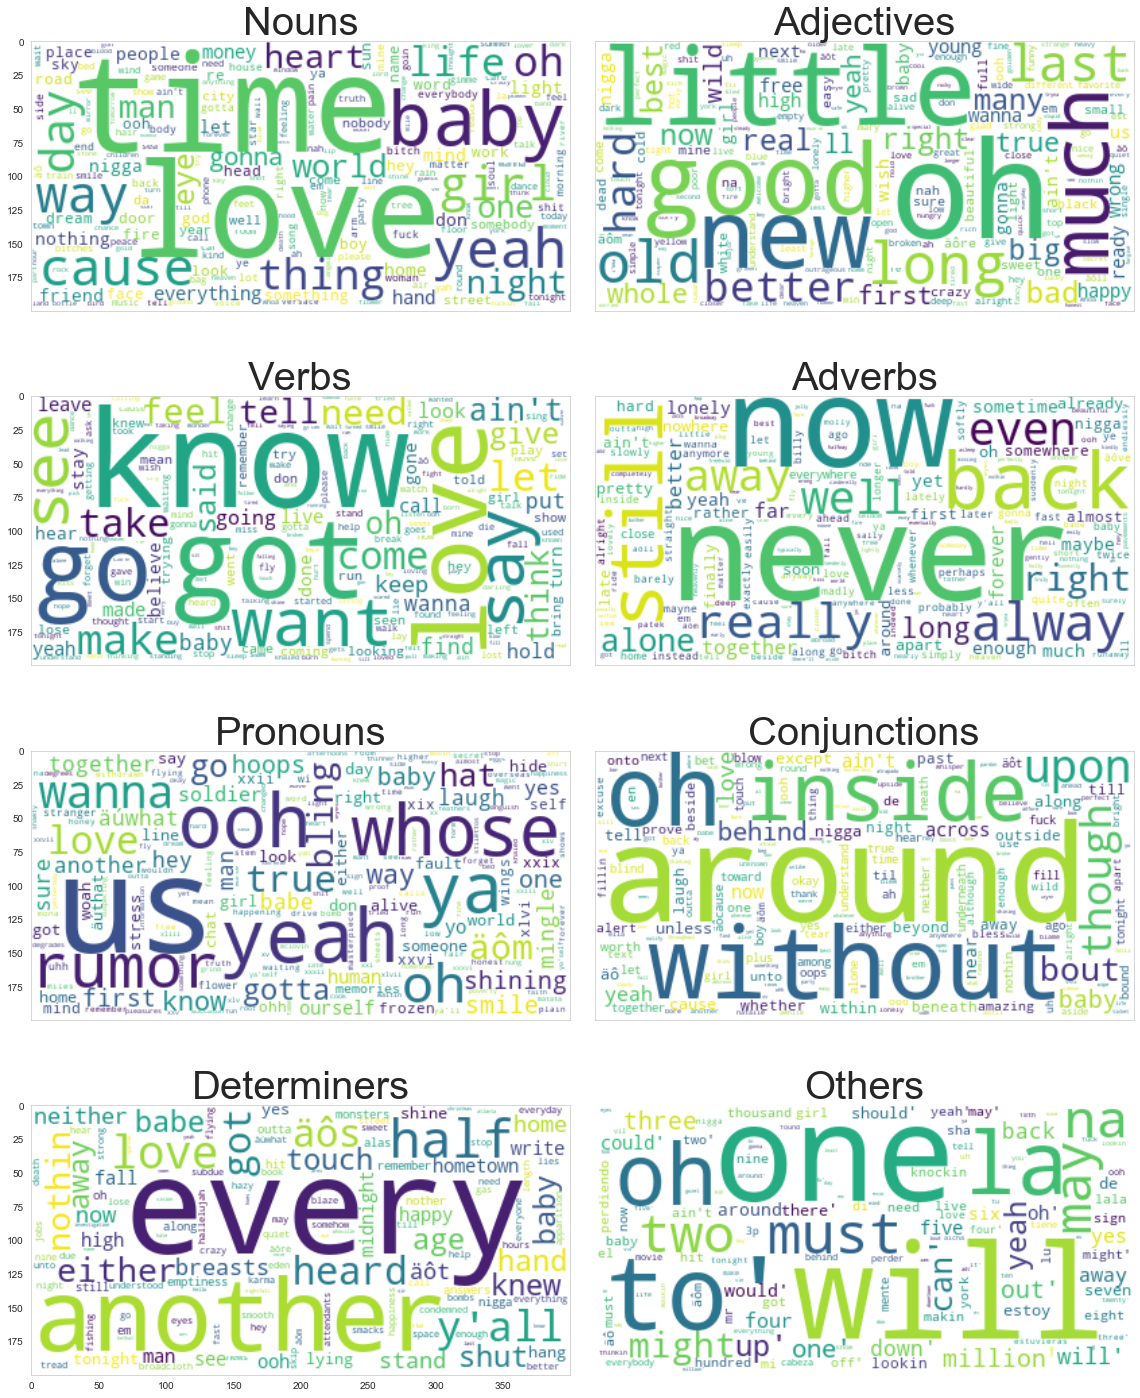

In [16]:
# Forming wordclouds of all the POS tags
plt.rcParams["axes.grid"] = False
stopwords = set(STOPWORDS)
wc =  WordCloud(background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=100,
                          collocations=False,  
                          random_state=42)
fig,axes = plt.subplots(4,2,figsize=(16,20),sharex=True,sharey=True)
fig.tight_layout()
for i,ax in enumerate(axes.flatten()):
    ax.imshow(wc.generate(twd.detokenize(z[i])),interpolation='bilinear')
    ax.set_title(x[i],fontsize=40)
plt.axis('off')
plt.margins(x=0, y=0)
plt.grid(None)
plt.show()    

## Lemmatizing the text

## Applying WordNetLemmatizer on the songs using NLTK POS_tags

In [17]:
wnl = WordNetLemmatizer()
from nltk.corpus import wordnet
from nltk import pos_tag

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [18]:
# Lemmatizes the text from raw_text column
songs['lemmatized_text'] = None
for i in songs.index:
    a = songs.loc[i,'raw_text'].replace('.','\n')
    songs.loc[i,'lemmatized_text'] = str()
    for j in lt.tokenize(a):
        b = twd.detokenize([wnl.lemmatize(word,get_wordnet_pos(word)) for word in tt.tokenize(j)])
        songs.loc[i,'lemmatized_text']+= b+'\n'

## Using TF-IDF Vectorizer to gauge the most active words per genre

In [26]:
a  = songs[['genre','lemmatized_text']].groupby('genre').aggregate({'lemmatized_text':'\n'.join})

country_vect = TfidfVectorizer(analyzer='word',
                               stop_words=stoplist_combined,ngram_range=(1,1),min_df=0)
matrix = country_vect.fit_transform(list(a['lemmatized_text']))
importance_matrix = pd.DataFrame(matrix.toarray(),columns =[name for name in country_vect.get_feature_names()],index = a.index)

F:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['mon'] not in stop_words.



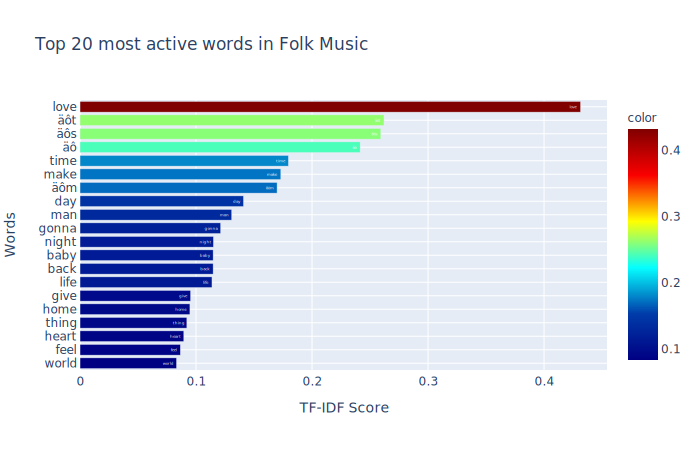

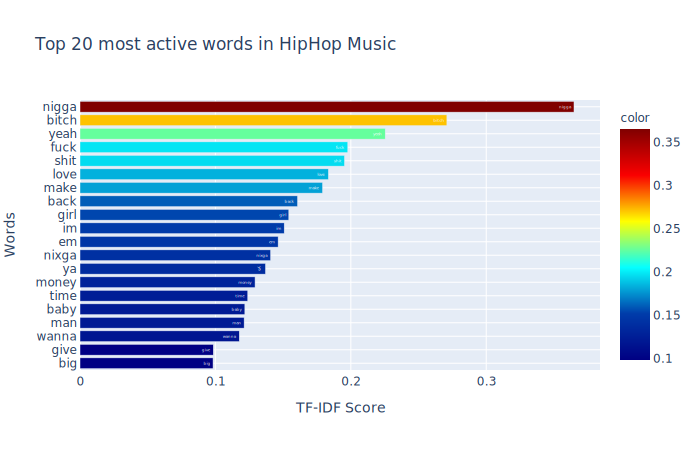

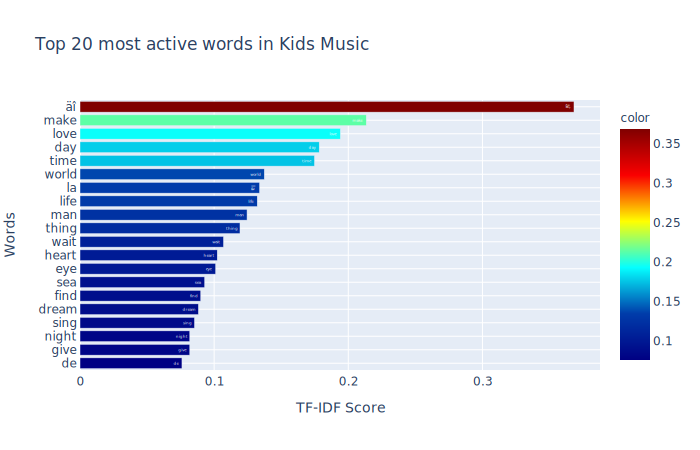

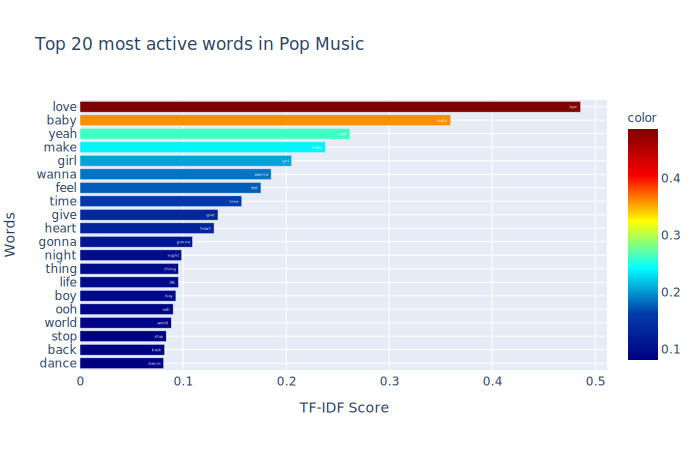

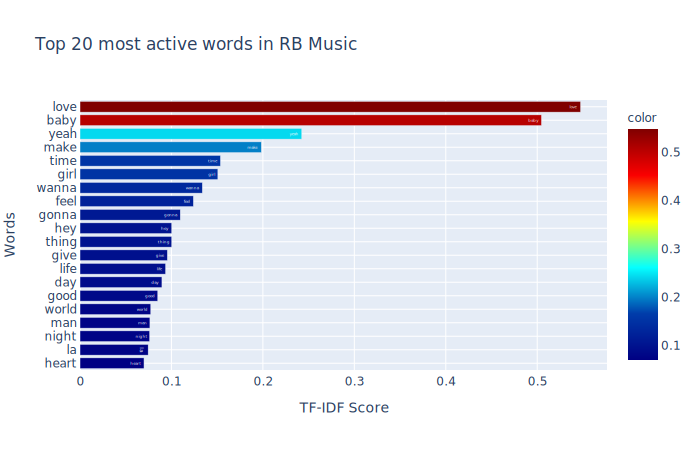

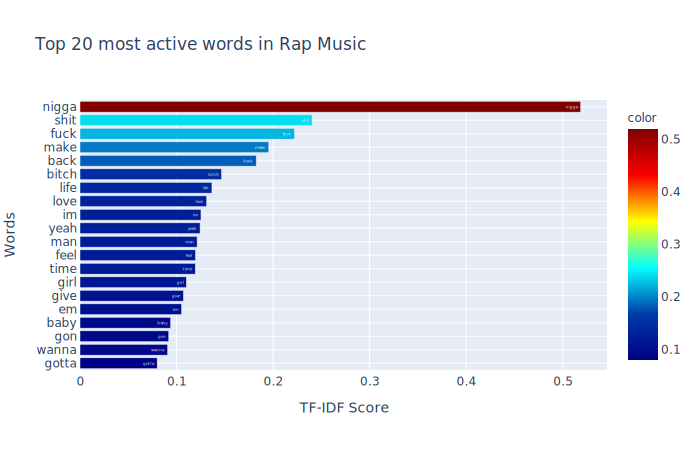

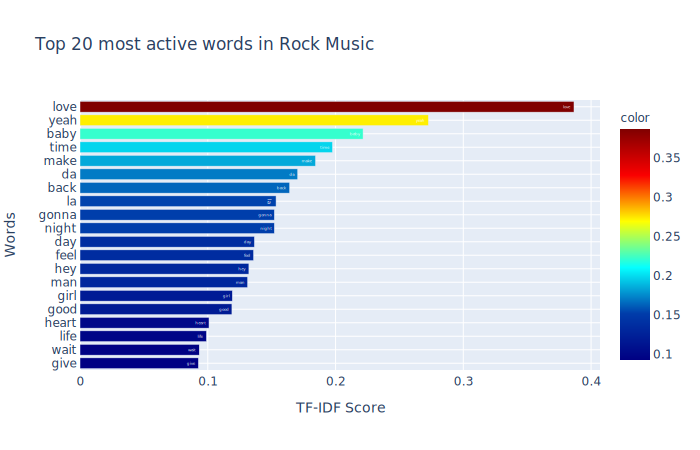

In [32]:
for i in a.index:
    p  =np.array(importance_matrix.loc[i,:])
    f = [np.array(country_vect.get_feature_names())[i] for i in p.argsort()[-20:]]
    g = [p[i] for i in p.argsort()[-20:]]
    fig = px.bar(y=f,x=g,title = 'Top 20 most active words in '+i+ ' Music',orientation='h',text=f,color=g,color_continuous_scale =px.colors.sequential.Jet)
    fig.update_traces(textposition='inside')
    fig.update_layout(
    yaxis_title = 'Words',
    xaxis_title = 'TF-IDF Score',
    yaxis = dict(tickmode= 'linear'))
    fig.show()

## Using TF-IDF to analyze n-grams of words occuring

In [21]:
country_vect = TfidfVectorizer(stop_words=stopwords_en,ngram_range=(2,5),min_df=0)
matrix = country_vect.fit_transform(list(a['lemmatized_text']))
importance_matrix = pd.DataFrame(matrix.toarray(),columns =[name for name in country_vect.get_feature_names()],index = a.index)

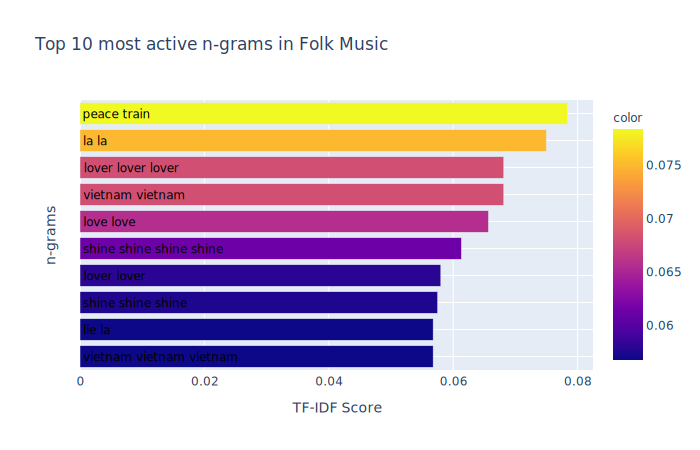

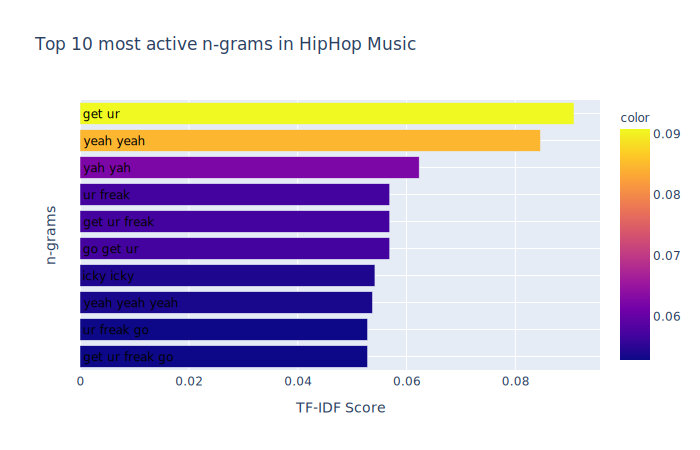

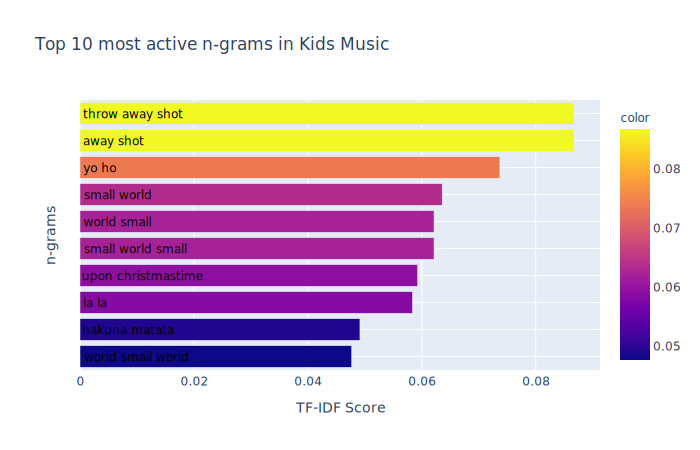

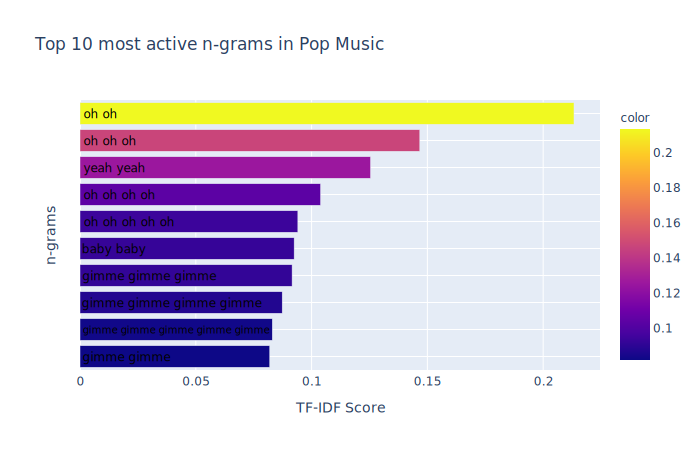

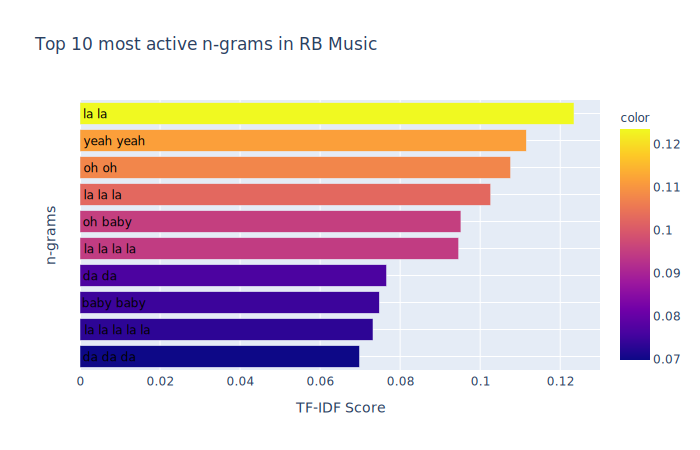

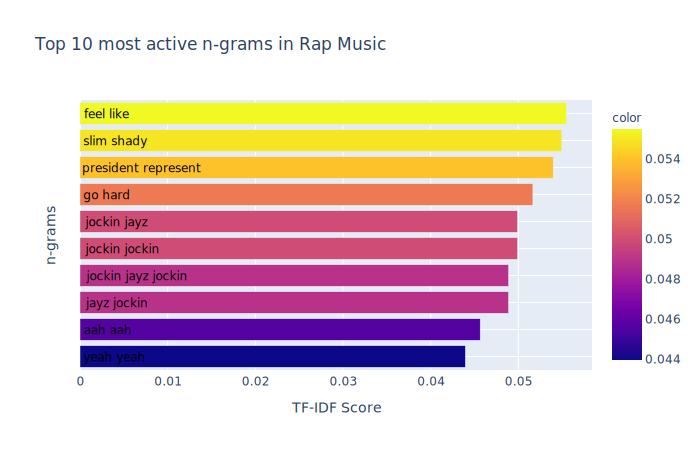

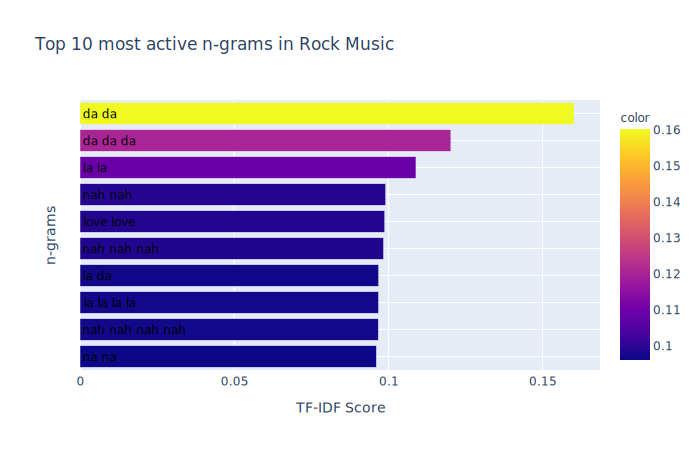

In [22]:
for i in a.index:
    p  =np.array(importance_matrix.loc[i,:])
    f = [np.array(country_vect.get_feature_names())[i] for i in p.argsort()[-10:]]
    g = [p[i] for i in p.argsort()[-10:]]
    fig = px.bar(y=f,x=g,title = 'Top 10 most active n-grams in '+i+' Music',orientation='h',text=f,color=g,color_continuous_scale =px.colors.sequential.Plasma)
    fig.update_traces(textposition='inside',insidetextanchor='start',textfont_size=12,textfont_color='black')
    fig.update_yaxes(showticklabels=False)
    fig.update_layout(
    yaxis_title = 'n-grams',
    xaxis_title = 'TF-IDF Score')
    fig.show()

We can see from the above graphs that the most active n-grams are the chorus lines from each song.

## Cosine Similarity between songs of different genres

F:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['mon'] not in stop_words.



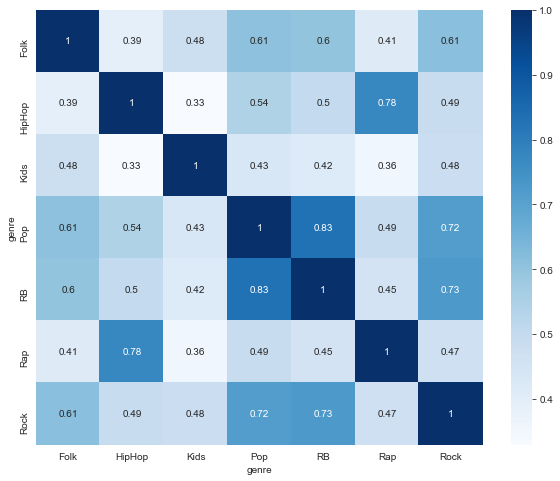

In [23]:
a  = songs[['genre','lemmatized_text']].groupby('genre').aggregate({'lemmatized_text':'\n'.join})
count_vec = TfidfVectorizer(stop_words=stoplist_combined,ngram_range=(1,3))
tfid = count_vec.fit_transform(a['lemmatized_text'])
pair_sim = (tfid*tfid.T).A
g = pd.DataFrame(pair_sim,index = a.index,columns = a.index)
""" Also defining a function which can tell us about the cosine similarity between any
two texts. It can be used later for analysis purposes"""

def cosine_sim(text1, text2):
    tfidf = count_vec.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

fig,ax = plt.subplots(figsize =(10,8))
sns.heatmap(g,annot=True,cmap = plt.cm.Blues,ax=ax)

## Some observations which can be made from the EDA

1. There are a lot of common words which appear in all types of genres such as 'like','love','know' and so on.
2. For HipHop and Rap music ,most of the most active words are innappropriate words.
3. For Pop and RB, most common words are 'love','baby','girl' and so on.
4. The most active n-grams ina ny song are the chorus lines.
5. It is said that HipHop music is a mixture of Pop and Rap music which can easily be determined by the Cosine Similarity heatmap.
6. Pop,RB and Rock are also quite similiar.
7. Kids music is the only genre which is quite separate from others.
8. As some genres of music are so similiar to each other ,the classifier which we are going to make may have low accuracy.

## Storing the processed data

In [24]:
songs.to_csv('data/processed_songs.csv')